In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import matplotlib as mpl

In [123]:
path = '../background/hyperparameters.csv'
df = pd.read_csv(path)

# order proteins by MW

mws = {'Chignolin': 10, 'Trp-cage': 20, 'BBA': 28, 'Villin': 35, 'WW-domain': 35, 'NTL9': 39, 'BBL': 47, 
      'Protein B': 47, 'Homeodomain': 52, 'Protein G': 56, 'a3D': 73, 'Lambda-repressor': 80}
df['n_res'] = df['Protein'].apply(lambda x: mws[x])
df.sort_values(by=['n_res'], inplace=True)
prot_order = df.copy(deep=True).Protein.unique()

# Create these as ordinal features so that they stay in this order when plotted (hopefully)
df['Protein'] = pd.Categorical(df['Protein'], ordered=True, categories=prot_order)



In [124]:
feats = df.loc[df.Hyperparameter=='feature', ['Citation', 'Protein', 'Value']]

feats = (feats.join(
    feats.Value.str
    .split(pat=',')
    .apply(pd.Series))
    .drop(['Value'], axis=1)
    .melt(id_vars=['Citation', 'Protein'], value_name='Feature')
    .drop(['variable'], axis=1)
    .dropna())
feats.Feature = feats.Feature.str.strip()
feats.head()

,Citation,Protein,Feature
0,A_Minimum_2018,Chignolin,alpha-dihedrals
1,A_Minimum_2018,Chignolin,alpha-dihedrals
2,Modeling_t2017,Chignolin,alpha-dihedrals
3,Quantitati2018,Chignolin,closest-distances
4,Optimized_2016,Chignolin,alpha-logistic-distances


# Protein feature

In [125]:
# order features by type and then alphabetical
feats['is_dihedral'] = feats.Feature.str.contains('dihed')
feats['is_distance'] = feats.Feature.str.contains('distance')
feats['is_contact'] = feats.Feature.str.contains('contact')
feats['is_angle'] = feats.Feature.str.contains('angle')
feats['misc'] = (~feats['is_dihedral']) | (~feats['is_distance']) | (~feats['is_contact']) | (~feats['is_angle']) 
feats.sort_values(by=['is_dihedral', 'is_contact', 'is_distance', 'misc', 'Feature'], inplace=True, ascending=False)
feat_order = feats.copy(deep=True).Feature.unique()


feats['Feature'] = pd.Categorical(feats['Feature'], ordered=True, categories=feat_order)

In [126]:
sns.set_style('white')

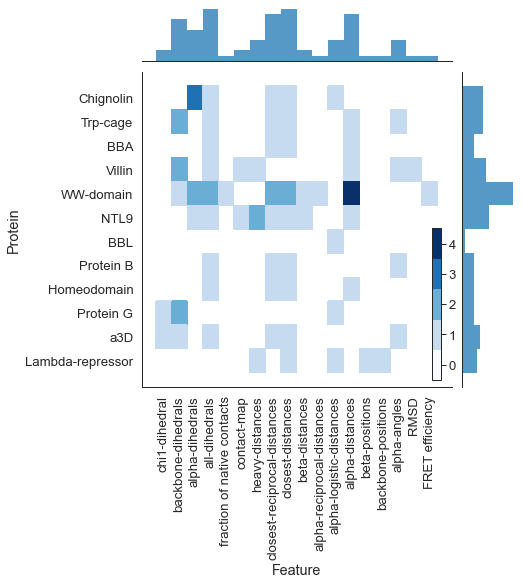

In [132]:

with sns.plotting_context('paper', font_scale=1.5):
    y, x = feats['Protein'], feats['Feature']
    g = sns.JointGrid()
    
    # plot the data
    sns.histplot(x=x,ax=g.ax_marg_x, fill=True, lw=0)
    sns.histplot(y=y,ax=g.ax_marg_y, fill=True, lw=0)
    sns.histplot(x=x, y=y, ax=g.ax_joint, cmap='Blues')
    # custom colorbar
    cmap = mpl.cm.Blues
    bounds = [0, 1, 2, 3, 4, 5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='neither')
    cbar_ax = g.fig.add_axes([0.77,0.1,  0.02, 0.35])
    cb2 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                    cmap=cmap,
                                    norm=norm,
                                    orientation='vertical', 
                                   ticks=mpl.ticker.FixedLocator([0.5, 1.5, 2.5, 3.5, 4.5]), 
                                   format=mpl.ticker.FixedFormatter([0, 1, 2, 3, 4]))
    

    g.fig.axes[0].tick_params(axis='x', labelrotation=90)
    plt.savefig('../figures/background_features.pdf')

# Markov lag times

In [128]:
mlags = df.loc[df.Hyperparameter.str.lower().str.contains('markov'), ['Citation', 'Protein', 'Value', 'units']]
mlags.dropna(axis=0, subset=['Value'], inplace=True)
mlags['Value'] = mlags['Value'].astype(float)

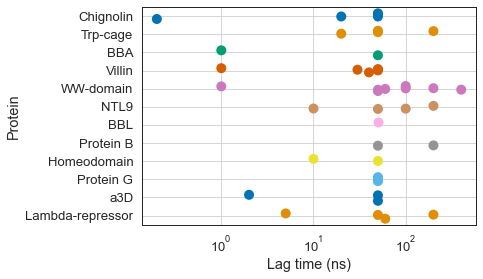

In [134]:
with sns.plotting_context('paper', font_scale=1.5):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.stripplot(data=mlags, y='Protein', x='Value',ax=ax, palette='colorblind', s=10,  jitter=0.2)
#     ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('Lag time (ns)')
    ax.set_xscale('log')
    ax.grid(axis='both')
    plt.savefig('../figures/background_lag_times.pdf')

# TICA parameters

In [62]:
tica = df.loc[df.Hyperparameter.str.lower().str.contains('tica'), ['Protein', 'Hyperparameter', 'Value', 'units']]

replace = {'kinetic-map': 1, 'commute-map': 2, 'none': 0, 'all': 200, '95pc_KV': np.nan}
def f(x):
    try: 
        return replace[x]
    except KeyError:
        return x

tica['Value'] = tica['Value'].apply(f)
tica.dropna(axis=0, subset=['Value'], inplace=True)
tica['Value'] = tica['Value'].astype(float)
tica = tica.loc[~tica.Hyperparameter.isin(['TICA stride', 'TICA scaling']), :]

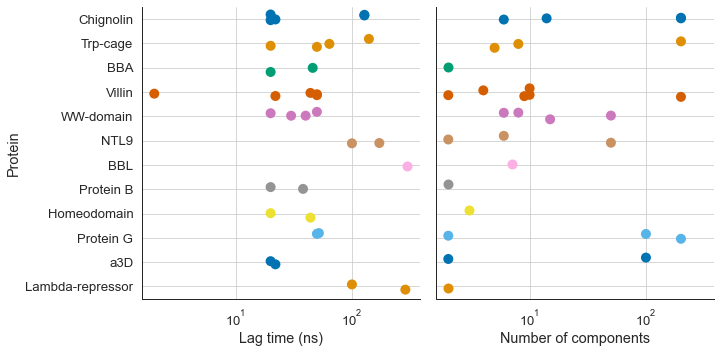

In [135]:
with sns.plotting_context('paper', font_scale=1.5):
    order = np.array(['TICA lag', 'TICA m'])
    
    g = sns.catplot(data=tica, col='Hyperparameter', y='Protein', x='Value', sharey=True, 
                    s=10, palette='colorblind', col_order=order, jitter=0.2)
    g.set_titles('')
    for ax in g.axes.flatten():
#         ax.tick_params(axis='x', rotation=90)
        ax.set_xscale('log')
        ax.grid(axis='both')
    lag_ax = g.axes[0, np.where(order=="TICA lag")[0][0]]
    m_ax = g.axes[0, np.where(order=="TICA m")[0][0]]
    lag_ax.set_xlabel('Lag time (ns)')
    m_ax.set_xlabel('Number of components')
    plt.savefig('../figures/background_tica.pdf')
    